# edges - Biodiversity, GLAM

0. Load data
1. Spatial Overlay: Intersect country boundaries with WWF ecoregions
2. Weight Calculation: Compute the percentage of each country occupied by each ecoregion
3. CF Matching: Merge Scherer et al. CFs based on eco_id
4. Output Generation: Creates a structured dataset ready for edges integration

In [1]:
import geopandas as gpd
import pandas as pd
# from shapely.ops import unary_union
import json
from collections import defaultdict
import country_converter as coco

# 0. Load data

### GLAM CF

https://zenodo.org/records/10114493

In [2]:
cfs_country = pd.read_csv("data/CF_country.csv", encoding='latin1')
cfs_country.head()

,objectid,iso3cd,romnam,m49code,species_group,kingdom,habitat_id,habitat,CF_occ_avg_reg,CF_occ_avg_reg_rsd,...,CF_tra_avg_reg,CF_tra_avg_reg_rsd,CF_tra_avg_glo,CF_tra_avg_glo_rsd,CF_tra_mar_reg,CF_tra_mar_reg_rsd,CF_tra_mar_glo,CF_tra_mar_glo_rsd,quality_reg,quality_glo
0,1,AFG,Afghanistan,4,Amphibians,Animalia,2.5,Cropland_LightIntense,4.887812e-12,0.975393,...,1.694477e-09,1.276619,9.872120e-14,1.793520,6.960850e-09,1.409165,1.650371e-13,1.847138,original,original
1,1,AFG,Afghanistan,4,Amphibians,Animalia,4.0,Cropland_Minimal,3.720958e-12,0.677332,...,1.146616e-09,0.801125,1.063796e-13,1.749844,5.813506e-09,1.630715,1.781719e-13,1.795493,original,original
2,1,AFG,Afghanistan,4,Amphibians,Animalia,5.0,Managed_forest_Intense,1.141284e-12,3.301034,...,3.939469e-10,3.814672,1.853284e-14,0.021747,4.895608e-10,4.076165,2.094475e-14,0.103940,original,original
3,1,AFG,Afghanistan,4,Amphibians,Animalia,6.0,Managed_forest_Light,2.527731e-13,1.973676,...,8.905553e-11,2.239198,5.793671e-15,2.137864,1.269691e-10,2.293947,9.778089e-15,3.056999,original,original
4,1,AFG,Afghanistan,4,Amphibians,Animalia,7.0,Managed_forest_Minimal,5.798995e-14,0.793558,...,1.716007e-11,1.036485,3.752058e-15,1.025518,3.280831e-11,0.938761,6.351398e-15,1.065939,original,original


In [3]:
cfs = pd.read_csv("data/CF.csv", encoding='latin1')
cfs.head()

,realm,biome,eco_id,eco_name,species_group,kingdom,habitat_id,habitat,CF_occ_avg_reg,CF_occ_avg_glo,CF_occ_mar_reg,CF_occ_mar_glo,CF_tra_avg_reg,CF_tra_avg_glo,CF_tra_mar_reg,CF_tra_mar_glo,quality_reg,quality_glo
0,AA,1,10101,Admiralty Islands lowland rain forests,Amphibians,Animalia,2.5,Cropland_LightIntense,4.101772e-11,6.545664e-15,6.226295e-11,9.936007e-15,7.587649e-09,1.210847e-12,1.167241e-08,1.862699e-12,proxy_type,proxy_type
1,AA,1,10101,Admiralty Islands lowland rain forests,Amphibians,Animalia,4.0,Cropland_Minimal,2.117044e-11,3.378407e-15,3.213572e-11,5.128262e-15,3.916206e-09,6.249535e-13,6.024469e-09,9.613930e-13,proxy_type,proxy_type
2,AA,1,10101,Admiralty Islands lowland rain forests,Amphibians,Animalia,5.0,Managed_forest_Intense,1.317317e-10,2.102193e-14,1.335184e-10,2.130705e-14,2.049554e-08,3.270706e-12,2.077352e-08,3.315066e-12,proxy_intensity,proxy_intensity
3,AA,1,10101,Admiralty Islands lowland rain forests,Amphibians,Animalia,6.0,Managed_forest_Light,3.592684e-11,5.733253e-15,3.641411e-11,5.811013e-15,5.589692e-09,8.920107e-13,5.665505e-09,9.041090e-13,original,original
4,AA,1,10101,Admiralty Islands lowland rain forests,Amphibians,Animalia,7.0,Managed_forest_Minimal,6.478740e-12,1.033886e-15,6.566611e-12,1.047909e-15,1.001336e-09,1.597946e-13,1.014917e-09,1.619619e-13,original,original


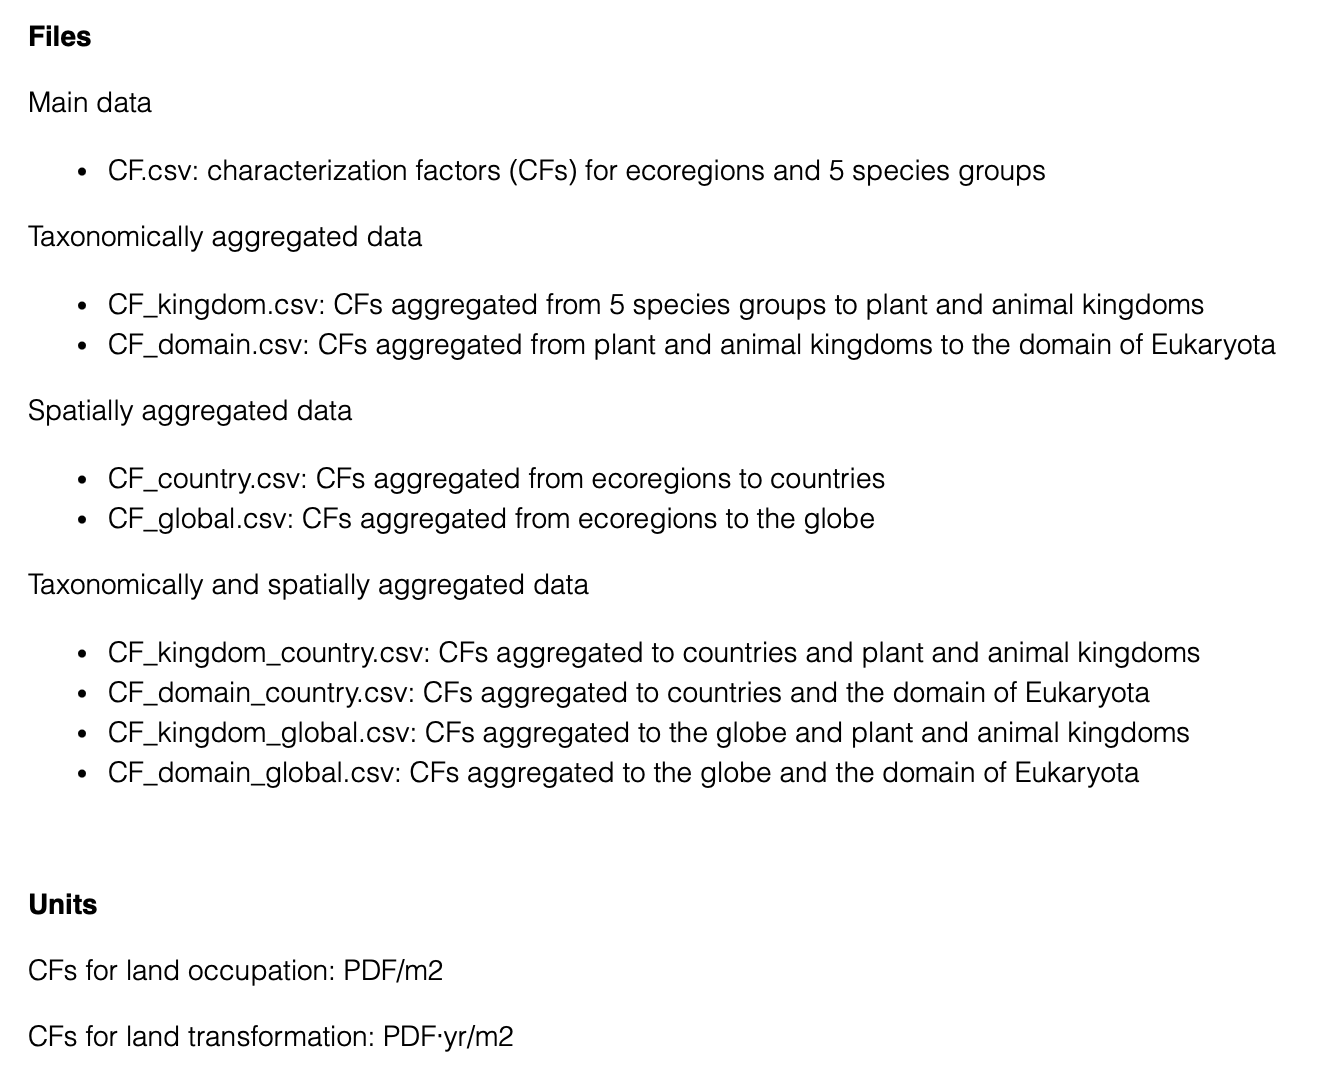

# Ecoregions

https://www.worldwildlife.org/publications/terrestrial-ecoregions-of-the-world

In [4]:
ecoregions = gpd.read_file("data/official/wwf_terr_ecos.shp")
# Ensure all are in the same CRS (WGS84)
ecoregions = ecoregions.to_crs("EPSG:4326")
# Create eco_id in ecoregions to match with CFs (from float to int)
ecoregions['eco_id'] = ecoregions['ECO_ID'].astype(int)

In [5]:
print(ecoregions.head())
print(ecoregions.columns)

   OBJECTID          AREA  PERIMETER                                 ECO_NAME  \
0         1     29.802942      0.219  Northern Mesoamerican Pacific mangroves   
1         2     11.977824      0.193  Northern Mesoamerican Pacific mangroves   
2         3  77301.372760    111.954                     Sinaloan dry forests   
3         4    215.489182      1.274  Northern Mesoamerican Pacific mangroves   
4         5     19.639089      0.363  Northern Mesoamerican Pacific mangroves   

  REALM  BIOME  ECO_NUM   ECO_ID  ECO_SYM  GBL_STAT  ... G200_STAT  \
0    NT   14.0      4.0  61404.0    119.0       1.0  ...       0.0   
1    NT   14.0      4.0  61404.0    119.0       1.0  ...       0.0   
2    NT    2.0     28.0  60228.0     98.0       1.0  ...       1.0   
3    NT   14.0      4.0  61404.0    119.0       1.0  ...       0.0   
4    NT   14.0      4.0  61404.0    119.0       1.0  ...       0.0   

   Shape_Leng  Shape_Area  area_km2  eco_code  PER_area  PER_area_1  \
0    0.219475    0.00

### Countries

https://www.naturalearthdata.com/downloads/10m-cultural-vectors/

We use map units, as we prefer, for example, to distinguish overseas regions of France.

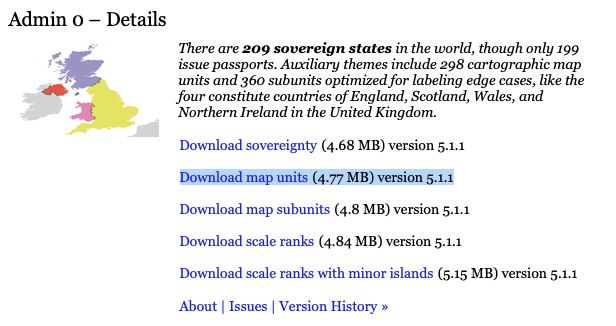

In [6]:
countries = gpd.read_file("data/ne_10m_admin_0_map_units/ne_10m_admin_0_map_units.shp")
# Ensure all are in the same CRS (WGS84)
countries = countries.to_crs("EPSG:4326")

In [7]:
print(f"Loaded {len(ecoregions)} ecoregions")
print(f"Loaded {len(countries)} countries")
print(f"Loaded {len(cfs)} CF records")

Loaded 14458 ecoregions
Loaded 298 countries
Loaded 51150 CF records


In [8]:
countries_projected = countries.to_crs("ESRI:54009")
countries['area_km2'] = countries_projected.geometry.area / 1e6
country_areas = countries.set_index('ISO_A3')['area_km2'].to_dict()
country_areas

{'IDN': 1892366.613635288,
 'MYS': 330072.24215046293,
 'CHL': 738017.590869393,
 'BOL': 1092895.4562693113,
 'PER': 1298027.443530577,
 'ARG': 2789349.0983146913,
 '-99': 0.09835497858727028,
 'CYP': 5407.60004640422,
 'IND': 3165389.005757481,
 'CHN': 9394400.41201053,
 'ISR': 22169.56057498407,
 'LBN': 10029.577474047659,
 'ETH': 1134602.9167184194,
 'SSD': 630939.4700157284,
 'KEN': 589637.1364584223,
 'MWI': 120116.51247629491,
 'TZA': 945157.8495601225,
 'GUF': 83738.9094930474,
 'SUR': 146090.75973087366,
 'GUY': 212614.39664711035,
 'MAR': 593756.8490366903,
 'ESH': 90899.97464797733,
 'CRI': 51475.48962436054,
 'NIC': 129466.58487113452,
 'COG': 347204.11493899877,
 'COD': 2340650.457490021,
 'BTN': 40578.24402617017,
 'UKR': 571456.3452909099,
 'BLR': 207094.82834368103,
 'NAM': 826670.8536212448,
 'ZAF': 1224180.4658882907,
 'SYR': 186101.43391646657,
 'MAF': 68.65327843456788,
 'SXM': 23.485656908999538,
 'OMN': 312789.2606449181,
 'UZB': 448182.44851229584,
 'KAZ': 2712412

# 1. Spatial overlay

In [9]:
overlay = gpd.overlay(countries, ecoregions, how='intersection')

# 2. Weight Calculation

In [10]:
# Calculate area of each intersection in km2
# Use an equal-area projection to get accurate areas
overlay_projected = overlay.to_crs("ESRI:54009")  # World Mollweide
overlay['intersection_area_km2'] = overlay_projected.geometry.area / 1e6  # Convert m² to km²

In [11]:
# Calculate the percentage of each ecoregion within each country
country_ecoregion = overlay.groupby(['ISO_A3', 'eco_id']).agg({
    'intersection_area_km2': 'sum',
    'NAME': 'first',  # Country name
    'ECO_NAME': 'first'  # Ecoregion name
}).reset_index()

In [12]:
# Calculate total country area for percentage calculation
country_totals = country_ecoregion.groupby('ISO_A3')['intersection_area_km2'].sum()
country_ecoregion = country_ecoregion.merge(
    country_totals.rename('country_total_km2'),
    left_on='ISO_A3',
    right_index=True
)

In [13]:
# Calculate weight factor (% of country area occupied by each ecoregion)
country_ecoregion['weight_factor'] = (
    country_ecoregion['intersection_area_km2'] / 
    country_ecoregion['country_total_km2']
)

# 3. CF matching

### Dataframe matching

In [14]:
country_ecoregion_cfs = country_ecoregion.merge(
    cfs,
    on='eco_id',
    how='left'
)

In [15]:
output_cols = [
    'ISO_A3',
    'NAME',
    'eco_id',
    'ECO_NAME',
    'intersection_area_km2',
    'weight_factor',
    'species_group',
    'habitat_id',
    'habitat',
    'CF_occ_avg_reg',
    'CF_occ_avg_glo',
    'CF_occ_mar_reg',
    'CF_occ_mar_glo',
    'CF_tra_avg_reg',
    'CF_tra_avg_glo',
    'CF_tra_mar_reg',
    'CF_tra_mar_glo',
    'quality_reg',
    'quality_glo'
]

final_output = country_ecoregion_cfs[output_cols].copy()

# Rename columns for clarity
final_output.columns = [
    'country_iso',
    'country_name',
    'ecoregion_id',
    'ecoregion_name',
    'area_km2',
    'weight_factor',
    'species_group',
    'habitat_id',
    'habitat_type',
    'cf_occupation_avg_regional',
    'cf_occupation_avg_global',
    'cf_occupation_marginal_regional',
    'cf_occupation_marginal_global',
    'cf_transformation_avg_regional',
    'cf_transformation_avg_global',
    'cf_transformation_marginal_regional',
    'cf_transformation_marginal_global',
    'quality_regional',
    'quality_global'
]

final_output = final_output[final_output['species_group'].notna()].copy()

In [16]:
final_output = final_output.sort_values(
    ['country_name', 'ecoregion_id', 'species_group', 'habitat_id'],
    ascending=True
)

In [17]:
final_output.to_csv("output/biomes_country_ecoregion_cfs_scherer.csv", index=False)
final_output.head()

,country_iso,country_name,ecoregion_id,ecoregion_name,area_km2,weight_factor,species_group,habitat_id,habitat_type,cf_occupation_avg_regional,cf_occupation_avg_global,cf_occupation_marginal_regional,cf_occupation_marginal_global,cf_transformation_avg_regional,cf_transformation_avg_global,cf_transformation_marginal_regional,cf_transformation_marginal_global,quality_regional,quality_global
5024,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,Amphibians,2.5,Cropland_LightIntense,4.594567e-12,1.374688e-15,9.087913e-12,2.719090e-15,2.691014e-09,8.051473e-13,5.322744e-09,1.592557e-12,original,original
5025,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,Amphibians,4.0,Cropland_Minimal,2.371390e-12,7.095161e-16,4.690536e-12,1.403401e-15,1.388911e-09,4.155599e-13,2.747222e-09,8.219648e-13,proxy_intensity,proxy_intensity
5026,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,Amphibians,5.0,Managed_forest_Intense,2.577149e-12,7.710791e-16,5.097522e-12,1.525171e-15,1.509423e-09,4.516170e-13,2.985592e-09,8.932846e-13,proxy_intensity,proxy_intensity
5027,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,Amphibians,6.0,Managed_forest_Light,7.028589e-13,2.102943e-16,1.390233e-12,4.159557e-16,4.116608e-10,1.231683e-13,8.142524e-10,2.436231e-13,original,original
5028,AFG,Afghanistan,40502,Western Himalayan subalpine conifer forests,172.624661,0.000268,Amphibians,7.0,Managed_forest_Minimal,1.267476e-13,3.792269e-17,2.507029e-13,7.500992e-17,7.374484e-11,2.206434e-14,1.458650e-10,4.364259e-14,original,original


In [18]:
# Get unique ecoregions per country and sum their weights
spain_check = final_output[final_output['country_iso'] == 'ESP'].groupby('ecoregion_id')['weight_factor'].first().sum()
spain_check

1.0

### Matching habitats to ecoinvent

Matching done according to: https://doi.org/10.1007/s11367-021-02003-y

In [19]:
import bw2data as bd
import bw2io as bi
bd.projects.set_current("bw25_ei311")
bf = bd.Database('biosphere')
sorted([m["categories"] for m in bf if "Transformation, from" in m["name"]])

/opt/homebrew/Caskroom/miniconda/base/envs/edges/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


09:24:30+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


[('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natural resource', 'land'),
 ('natur

In [20]:
occupation_flows = {
    'Occupation, annual crop': 'Cropland_Intense',
    'Occupation, annual crop, flooded crop': 'Cropland_Intense',
    'Occupation, annual crop, greenhouse': 'Urban_Light',
    'Occupation, annual crop, irrigated': 'Cropland_Intense',
    'Occupation, annual crop, irrigated, extensive': 'Cropland_Light',
    'Occupation, annual crop, irrigated, intensive': 'Cropland_Intense',
    'Occupation, annual crop, non-irrigated': 'Cropland_Intense',
    'Occupation, annual crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Occupation, annual crop, non-irrigated, intensive': 'Cropland_Intense',
    'Occupation, arable land, unspecified use': 'Cropland_Intense',
    # 'Occupation, arable, conservation tillage (obsolete)': '',
    # 'Occupation, arable, conventional tillage (obsolete)': '',
    # 'Occupation, arable, reduced tillage (obsolete)': '',
    # 'Occupation, bare area (non-use)': '',
    'Occupation, construction site': 'Urban_Intense',
    'Occupation, cropland fallow (non-use)': 'Cropland_Minimal',
    'Occupation, dump site': 'Urban_Intense',
    'Occupation, field margin/hedgerow': 'Cropland_Minimal',
    'Occupation, forest, extensive': 'Pasture_Light',
    'Occupation, forest, intensive': 'Managed_forest_Intense',
    'Occupation, forest, primary (non-use)': 'Managed_forest_Minimal',
    'Occupation, forest, secondary (non-use)': 'Pasture_Light',
    'Occupation, forest, unspecified': 'Managed_forest_Intense',
    'Occupation, grassland, natural (non-use)': 'Pasture_Minimal',
    'Occupation, grassland, natural, for livestock grazing': 'Pasture_Minimal',
    'Occupation, heterogeneous, agricultural': 'Cropland_Minimal',
    'Occupation, industrial area': 'Urban_Intense',
    # 'Occupation, inland waterbody, unspecified': '',
    # 'Occupation, lake, artificial': '',
    # 'Occupation, lake, natural (non-use)': '',
    'Occupation, mineral extraction site': 'Urban_Intense',
    'Occupation, pasture, man made': 'Pasture_Intense',
    'Occupation, pasture, man made, extensive': 'Pasture_Light',
    'Occupation, pasture, man made, intensive': 'Pasture_Intense',
    'Occupation, permanent crop': 'Cropland_Intense',
    'Occupation, permanent crop, irrigated': 'Cropland_Intense',
    'Occupation, permanent crop, irrigated, extensive': 'Cropland_Light',
    'Occupation, permanent crop, irrigated, intensive': 'Cropland_Intense',
    'Occupation, permanent crop, non-irrigated': 'Cropland_Intense',
    'Occupation, permanent crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Occupation, permanent crop, non-irrigated, intensive': 'Cropland_Intense',
    # 'Occupation, river, artificial': '',
    # 'Occupation, river, natural (non-use)': '',
    # 'Occupation, seabed, drilling and mining': '',
    # 'Occupation, seabed, infrastructure': '',
    # 'Occupation, seabed, natural (non-use)': '',
    # 'Occupation, seabed, unspecified': '',
    'Occupation, shrub land, sclerophyllous': 'Managed_forest_Minimal',
    # 'Occupation, snow and ice (non-use)': '',
    'Occupation, traffic area, rail network': 'Urban_Intense',
    'Occupation, traffic area, rail/road embankment': 'Urban_Light',
    'Occupation, traffic area, road network': 'Urban_Intense',
    'Occupation, unspecified': 'Urban_Intense',
    'Occupation, unspecified, natural (non-use)': 'Pasture_Minimal',
    'Occupation, urban, continuously built': 'Urban_Intense',
    'Occupation, urban, discontinuously built': 'Urban_Light',
    'Occupation, urban, green area': 'Urban_Minimal',
    'Occupation, urban/industrial fallow (non-use)': 'Urban_Light',
    # 'Occupation, wetland, coastal (non-use)': '',
    # 'Occupation, wetland, inland (non-use)': '',
}

In [21]:
transformation_to_flows = {
    'Transformation, to annual crop': 'Cropland_Intense',
    'Transformation, to annual crop, flooded crop': 'Cropland_Intense',
    'Transformation, to annual crop, greenhouse': 'Urban_Light',
    'Transformation, to annual crop, irrigated': 'Cropland_Intense',
    'Transformation, to annual crop, irrigated, extensive': 'Cropland_Light',
    'Transformation, to annual crop, irrigated, intensive': 'Cropland_Intense',
    'Transformation, to annual crop, non-irrigated': 'Cropland_Intense',
    'Transformation, to annual crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Transformation, to annual crop, non-irrigated, intensive': 'Cropland_Intense',
    'Transformation, to arable land, unspecified use': 'Cropland_Intense',
    # 'Transformation, to bare area (non-use)': '',
    'Transformation, to cropland fallow (non-use)': 'Cropland_Minimal',
    'Transformation, to dump site': 'Urban_Intense',
    'Transformation, to dump site, inert material landfill': 'Urban_Intense',
    'Transformation, to dump site, residual material landfill': 'Urban_Intense',
    'Transformation, to dump site, sanitary landfill': 'Urban_Intense',
    'Transformation, to dump site, slag compartment': 'Urban_Intense',
    'Transformation, to field margin/hedgerow': 'Cropland_Minimal',
    'Transformation, to forest, extensive': 'Managed_forest_Light',
    'Transformation, to forest, intensive': 'Managed_forest_Intense',
    'Transformation, to forest, primary (non-use)': 'Pasture_Minimal',
    'Transformation, to forest, secondary (non-use)': 'Managed_forest_Light',
    'Transformation, to forest, unspecified': 'Managed_forest_Intense',
    'Transformation, to grassland, natural (non-use)': 'Pasture_Minimal',
    'Transformation, to grassland, natural, for livestock grazing': 'Pasture_Minimal',
    'Transformation, to heterogeneous, agricultural': 'Cropland_Minimal',
    'Transformation, to industrial area': 'Urban_Intense',
    # 'Transformation, to inland waterbody, unspecified': '',
    # 'Transformation, to lake, artificial': '',
    # 'Transformation, to lake, natural (non-use)': '',
    'Transformation, to mineral extraction site': 'Urban_Intense',
    'Transformation, to pasture, man made': 'Pasture_Intense',
    'Transformation, to pasture, man made, extensive': 'Pasture_Light',
    'Transformation, to pasture, man made, intensive': 'Pasture_Intense',
    'Transformation, to permanent crop': 'Cropland_Intense',
    'Transformation, to permanent crop, irrigated': 'Cropland_Intense',
    'Transformation, to permanent crop, irrigated, extensive': 'Cropland_Light',
    'Transformation, to permanent crop, irrigated, intensive': 'Cropland_Intense',
    'Transformation, to permanent crop, non-irrigated': 'Cropland_Intense',
    'Transformation, to permanent crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Transformation, to permanent crop, non-irrigated, intensive': 'Cropland_Intense',
    # 'Transformation, to river, artificial': '',
    # 'Transformation, to river, natural (non-use)': '',
    # 'Transformation, to seabed, drilling and mining': '',
    # 'Transformation, to seabed, infrastructure': '',
    # 'Transformation, to seabed, natural (non-use)': '',
    # 'Transformation, to seabed, unspecified': '',
    'Transformation, to shrub land, sclerophyllous': 'Pasture_Minimal',
    # 'Transformation, to snow and ice (non-use)': '',
    'Transformation, to traffic area, rail network': 'Urban_Intense',
    'Transformation, to traffic area, rail/road embankment': 'Urban_Light',
    'Transformation, to traffic area, road network': 'Urban_Intense',
    'Transformation, to unknown': 'Urban_Intense', # Added - Matched to unspecified
    'Transformation, to unspecified': 'Urban_Intense',
    'Transformation, to unspecified, natural (non-use)': 'Pasture_Minimal',
    'Transformation, to urban, continuously built': 'Urban_Intense',
    'Transformation, to urban, discontinuously built': 'Urban_Light',
    'Transformation, to urban, green area': 'Urban_Minimal',
    'Transformation, to urban/industrial fallow (non-use)': 'Urban_Light',
    # 'Transformation, to wetland, coastal (non-use)': '',
    # 'Transformation, to wetland, inland (non-use)': '',   
}

In [22]:
transformation_from_flows = {
    'Transformation, from annual crop': 'Cropland_Intense',
    'Transformation, from annual crop, flooded crop': 'Cropland_Intense',
    'Transformation, from annual crop, greenhouse': 'Urban_Light',
    'Transformation, from annual crop, irrigated': 'Cropland_Intense',
    'Transformation, from annual crop, irrigated, extensive': 'Cropland_Light',
    'Transformation, from annual crop, irrigated, intensive': 'Cropland_Intense',
    'Transformation, from annual crop, non-irrigated': 'Cropland_Intense',
    'Transformation, from annual crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Transformation, from annual crop, non-irrigated, intensive': 'Cropland_Intense',
    'Transformation, from arable land, unspecified use': 'Cropland_Intense',
    # 'Transformation, from bare area (non-use)': '',
    'Transformation, from cropland fallow (non-use)': 'Cropland_Minimal',
    'Transformation, from dump site': 'Urban_Intense',
    'Transformation, from dump site, inert material landfill': 'Urban_Intense',
    'Transformation, from dump site, residual material landfill': 'Urban_Intense',
    'Transformation, from dump site, sanitary landfill': 'Urban_Intense',
    'Transformation, from dump site, slag compartment': 'Urban_Intense',
    'Transformation, from field margin/hedgerow': 'Cropland_Minimal',
    'Transformation, from forest, extensive': 'Managed_forest_Light',
    'Transformation, from forest, intensive': 'Managed_forest_Intense',
    'Transformation, from forest, primary (non-use)': 'Pasture_Minimal',
    'Transformation, from forest, secondary (non-use)': 'Managed_forest_Light',
    'Transformation, from forest, unspecified': 'Managed_forest_Intense',
    'Transformation, from grassland, natural (non-use)': 'Pasture_Minimal',
    'Transformation, from grassland, natural, for livestock grazing': 'Pasture_Minimal',
    'Transformation, from heterogeneous, agricultural': 'Cropland_Minimal',
    'Transformation, from industrial area': 'Urban_Intense',
    # 'Transformation, from inland waterbody, unspecified': '',
    # 'Transformation, from lake, artificial': '',
    # 'Transformation, from lake, natural (non-use)': '',
    'Transformation, from mineral extraction site': 'Urban_Intense',
    'Transformation, from pasture, man made': 'Pasture_Intense',
    'Transformation, from pasture, man made, extensive': 'Pasture_Light',
    'Transformation, from pasture, man made, intensive': 'Pasture_Intense',
    'Transformation, from permanent crop': 'Cropland_Intense',
    'Transformation, from permanent crop, irrigated': 'Cropland_Intense',
    'Transformation, from permanent crop, irrigated, extensive': 'Cropland_Light',
    'Transformation, from permanent crop, irrigated, intensive': 'Cropland_Intense',
    'Transformation, from permanent crop, non-irrigated': 'Cropland_Intense',
    'Transformation, from permanent crop, non-irrigated, extensive': 'Cropland_Minimal',
    'Transformation, from permanent crop, non-irrigated, intensive': 'Cropland_Intense',
    # 'Transformation, from river, artificial': '',
    # 'Transformation, from river, natural (non-use)': '',
    # 'Transformation, from seabed, drilling and mining': '',
    # 'Transformation, from seabed, infrastructure': '',
    # 'Transformation, from seabed, natural (non-use)': '',
    # 'Transformation, from seabed, unspecified': '',
    'Transformation, from shrub land, sclerophyllous': 'Pasture_Minimal',
    # 'Transformation, from snow and ice (non-use)': '',
    'Transformation, from traffic area, rail network': 'Urban_Intense',
    'Transformation, from traffic area, rail/road embankment': 'Urban_Light',
    'Transformation, from traffic area, road network': 'Urban_Intense',
    'Transformation, from unknown': 'Urban_Intense', # Added - Matched to unspecified
    'Transformation, from unspecified': 'Urban_Intense',
    'Transformation, from unspecified, natural (non-use)': 'Pasture_Minimal',
    'Transformation, from urban, continuously built': 'Urban_Intense',
    'Transformation, from urban, discontinuously built': 'Urban_Light',
    'Transformation, from urban, green area': 'Urban_Minimal',
    'Transformation, from urban/industrial fallow (non-use)': 'Urban_Light',
    # 'Transformation, from wetland, coastal (non-use)': '',
    # 'Transformation, from wetland, inland (non-use)': '',   
}

# 4. JSON generation

In [23]:
cc = coco.CountryConverter()
species_groups = final_output['species_group'].unique()
print(f"Found {len(species_groups)} species groups: {species_groups}")

Found 5 species groups: ['Amphibians' 'Birds' 'Mammals' 'Plants' 'Reptiles']


In [24]:
def generate_occupation_json(species_group):
    """Generate JSON for occupation flows for a specific species group"""
    
    exchanges = []
    
    # Group by country and biosphere flow
    for flow_name, habitat_type in occupation_flows.items():
        
        # Get all countries
        countries_list = final_output['country_iso'].unique()
        
        for country in countries_list:
            # Get country-level CF from cfs_country for this species group
            country_cf_row = cfs_country[
                (cfs_country['iso3cd'] == country) &
                (cfs_country['habitat'] == habitat_type) &
                (cfs_country['species_group'] == species_group)
            ]
            
            # If no country-level CF available, skip this country-habitat combination
            if len(country_cf_row) == 0:
                continue
            
            # Get the country-level CF value
            country_cf_value = country_cf_row['CF_occ_avg_reg'].iloc[0]
            
            # Filter ecoregion data for uncertainty parameters
            country_data = final_output[
                (final_output['country_iso'] == country) &
                (final_output['habitat_type'] == habitat_type) &
                (final_output['species_group'] == species_group)
            ]
            
            if len(country_data) == 0:
                continue
            
            # Get unique ecoregions for uncertainty
            unique_ecoregions = country_data.drop_duplicates(subset=['ecoregion_id'])
            
            # Prepare uncertainty parameters from ecoregion data
            values = unique_ecoregions['cf_occupation_avg_regional'].tolist()
            weights = unique_ecoregions['weight_factor'].tolist()
            
            # Get country area
            country_area = country_areas.get(country, 0)
            
            exchange = {
                "supplier": {
                    "name": flow_name,
                    "categories": ["natural resource", "land"],
                    "matrix": "biosphere"
                },
                "consumer": {
                    "location": cc.convert(names=country, to='ISO2'),
                    "matrix": "technosphere"
                },
                "value": float(country_cf_value),
                "weight": float(country_area),
                "uncertainty": {
                    "distribution": "discrete_empirical",
                    "parameters": {
                        "values": [float(v) for v in values],
                        "weights": [float(w) for w in weights]
                    }
                }
            }
            
            exchanges.append(exchange)
    
    output = {
        "name": f"ecoinvent 3.10/3.11 - Scherer et al. 2023 - Land occupation, biodiversity damage - {species_group}",
        "unit": "PDF.yr",
        "version": "0.1",
        "description": f"Characterization factors for land occupation impacts on biodiversity ({species_group}) based on Scherer et al. 2023: https://doi.org/10.5281/zenodo.10114492",
        "species_group": species_group,
        "strategies": [
            "map_exchanges",
            "map_aggregate_locations",
            "map_dynamic_locations",
            "map_contained_locations",
            "map_remaining_locations_to_global"
        ],
        "exchanges": exchanges
    }
    
    return output

In [25]:
def generate_transformation_json(species_group):
    """Generate JSON for transformation flows (from and to combined) for a specific species group"""
    
    exchanges = []
    
    # Process transformation FROM flows
    for flow_name, habitat_type in transformation_from_flows.items():
        
        countries_list = final_output['country_iso'].unique()
        
        for country in countries_list:
            # Get country-level CF from cfs_country for this species group
            country_cf_row = cfs_country[
                (cfs_country['iso3cd'] == country) &
                (cfs_country['habitat'] == habitat_type) &
                (cfs_country['species_group'] == species_group)
            ]
            
            if len(country_cf_row) == 0:
                continue
            
            # Get the country-level CF value for transformation
            country_cf_value = country_cf_row['CF_tra_avg_reg'].iloc[0]
            
            # Filter ecoregion data for uncertainty parameters
            country_data = final_output[
                (final_output['country_iso'] == country) &
                (final_output['habitat_type'] == habitat_type) &
                (final_output['species_group'] == species_group)
            ]
            
            if len(country_data) == 0:
                continue
            
            unique_ecoregions = country_data.drop_duplicates(subset=['ecoregion_id'])
            
            values = unique_ecoregions['cf_transformation_avg_regional'].tolist()
            weights = unique_ecoregions['weight_factor'].tolist()
            
            country_area = country_areas.get(country, 0)
            
            
            exchange = {
                "supplier": {
                    "name": flow_name,
                    "categories": ["natural resource", "land"],
                    "matrix": "biosphere"
                },
                "consumer": {
                    "location": cc.convert(names=country, to='ISO2'),
                    "matrix": "technosphere"
                },
                "value": float(country_cf_value),
                "weight": float(country_area),
                "uncertainty": {
                    "distribution": "discrete_empirical",
                    "parameters": {
                        "values": [float(v) for v in values],
                        "weights": [float(w) for w in weights]
                    }
                }
            }
            
            exchanges.append(exchange)
    
    # Process transformation TO flows
    for flow_name, habitat_type in transformation_to_flows.items():
        
        countries_list = final_output['country_iso'].unique()
        
        for country in countries_list:
            # Get country-level CF from cfs_country for this species group
            country_cf_row = cfs_country[
                (cfs_country['iso3cd'] == country) &
                (cfs_country['habitat'] == habitat_type) &
                (cfs_country['species_group'] == species_group)
            ]
            
            if len(country_cf_row) == 0:
                continue
            
            # Get the country-level CF value for transformation
            country_cf_value = country_cf_row['CF_tra_avg_reg'].iloc[0]
            
            # Filter ecoregion data for uncertainty parameters
            country_data = final_output[
                (final_output['country_iso'] == country) &
                (final_output['habitat_type'] == habitat_type) &
                (final_output['species_group'] == species_group)
            ]
            
            if len(country_data) == 0:
                continue
            
            unique_ecoregions = country_data.drop_duplicates(subset=['ecoregion_id'])
            
            values = unique_ecoregions['cf_transformation_avg_regional'].tolist()
            weights = unique_ecoregions['weight_factor'].tolist()
            
            country_area = country_areas.get(country, 0)
            
            exchange = {
                "supplier": {
                    "name": flow_name,
                    "categories": ["natural resource", "land"],
                    "matrix": "biosphere"
                },
                "consumer": {
                    "location": cc.convert(names=country, to='ISO2'),
                    "matrix": "technosphere"
                },
                "value": float(country_cf_value),
                "weight": float(country_area),
                "uncertainty": {
                    "distribution": "discrete_empirical",
                    "parameters": {
                        "values": [float(v) for v in values],
                        "weights": [float(w) for w in weights]
                    }
                }
            }
            
            exchanges.append(exchange)
    
    output = {
        "name": f"ecoinvent 3.10/3.11 - Scherer et al. 2023 - Land transformation, biodiversity damage - {species_group}",
        "unit": "PDF.yr",
        "version": "0.1",
        "description": f"Characterization factors for land transformation impacts on biodiversity ({species_group}) based on Scherer et al. 2023: https://doi.org/10.5281/zenodo.10114492",
        "species_group": species_group,
        "strategies": [
            "map_exchanges",
            "map_aggregate_locations",
            "map_dynamic_locations",
            "map_contained_locations",
            "map_remaining_locations_to_global"
        ],
        "exchanges": exchanges
    }
    
    return output

In [26]:
for species_group in species_groups:
    print(f"\n--- Processing {species_group} ---")
    
    # Generate occupation JSON for this species group
    print(f"\n=== Generating Occupation JSON for {species_group} ===")
    occupation_json = generate_occupation_json(species_group)
    
    # Generate transformation JSON for this species group
    print(f"\n=== Generating Transformation JSON for {species_group} ===")
    transformation_json = generate_transformation_json(species_group)
    
    # Save to files with species group in filename
    species_group_clean = species_group.replace(' ', '_').lower()
    
    occupation_filename = f"output/biodiversity_scherer_occupation_average_{species_group_clean}.json"
    transformation_filename = f"output/biodiversity_scherer_transformation_average_{species_group_clean}.json"
    
    with open(occupation_filename, "w") as f:
        json.dump(occupation_json, f, indent=2)
    
    with open(transformation_filename, "w") as f:
        json.dump(transformation_json, f, indent=2)


--- Processing Amphibians ---

=== Generating Occupation JSON for Amphibians ===

=== Generating Transformation JSON for Amphibians ===

--- Processing Birds ---

=== Generating Occupation JSON for Birds ===

=== Generating Transformation JSON for Birds ===

--- Processing Mammals ---

=== Generating Occupation JSON for Mammals ===

=== Generating Transformation JSON for Mammals ===

--- Processing Plants ---

=== Generating Occupation JSON for Plants ===

=== Generating Transformation JSON for Plants ===

--- Processing Reptiles ---

=== Generating Occupation JSON for Reptiles ===

=== Generating Transformation JSON for Reptiles ===
